# Exploring sybword segmentation based on BPE, DPE, morphology and "transition freedom" 

### Test coprus based on https://arxiv.org/pdf/2005.06606.pdf (with numbers removed)



In [444]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd
import matplotlib.pyplot as plt

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']


from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *

#TODO move to model loading/setting
def update_grand_counts(base):
    grand_counts = {}
    counts = base.model[0]
    for e in counts:
        n = len(e)
        if not n in grand_counts:
            grand_counts[n] = 0
        grand_counts[n] += counts[e]
    base.grand_counts = grand_counts

def gram_tf(base,gram):
    m = base.model
    tf1 = len(m[1][gram]) if gram in m[1] else 0
    tf2 = len(m[2][gram]) if gram in m[2] else 0
    return tf1+tf2

def update_max_freedoms(base):
    max_freedoms = {}
    counts = base.model[0]
    for e in counts:
        n = len(e)
        if not n in max_freedoms:
            max_freedoms[n] = 0
        tf = gram_tf(base,e)
        if max_freedoms[n] < tf:
            max_freedoms[n] = tf
    base.max_freedoms = max_freedoms

def chunk_tf(base,gram):
    m = base.model
    tf1 = len(m[1][gram]) if gram in m[1] else 0
    tf2 = len(m[2][gram]) if gram in m[2] else 0
    return (tf1+tf2) / base.max_freedoms[len(gram)]


In [384]:
from math import exp, log

def root_n(x,n):
    return exp(log(x)/n)

def eval_split_log_div_cnt(base,split,debug=False):
    f = base.model[0]
    p = 1
    for t in split:
        cnt = f[t] if t in f else 0
        cnt /= len(t)
        v = math.log2(cnt)
        p = p * v
    return p

def eval_split_root(base,split,debug=False):
    f = base.model[0]
    p = 1.0
    for t in split:
        cnt = f[t] if t in f else 0
        p = p * cnt * len(t)
    if debug:
        print(p)
    return p if p == 0 or len(split) == 1 else root_n(p,len(split))
    
def eval_avg_log(base,split,extra_len_discount=False,debug=False):
    f = base.model[0]
    p = 0.0
    for t in split:
        cnt = f[t] if t in f else 0
        if extra_len_discount:
            p = p + math.log(cnt*len(t)*len(t)+1)
        else:
            p = p + math.log(cnt*len(t)+1)
    if debug:
        print(p)
    return p / len(split)

# https://en.wikipedia.org/wiki/Mutual_information
def eval_mi_chunk(base,chunk,log=True,debug=False):
    f = base.model[0]
    joint_f = f[chunk]/base.grand_counts[len(chunk)] if chunk in f else 0 # P(A,B,...)
    singles = list(chunk)
    p = 1.0
    for single in singles:
        single_f = f[single] if single in f else 0
        p *= single_f/base.grand_counts[1] # P(A)
    if debug:
        print(chunk,joint_f,singles,p)
    #return math.log(joint_f/p) if log else joint_f/p # joing_f == 0 => Math Domain Error
    return joint_f * math.log(joint_f/p) if log and joint_f > 0 else joint_f/p # cheating...
    #return math.log(joint_f/p) if log and joint_f > 0 else joint_f/p # cheating...

#TODO try multiplication instead!?

def eval_mi_sum(base,split,debug=False):
    f = base.model[0]
    sum_mi = 0
    for t in split:
        mi = eval_mi_chunk(base,t,debug=False)
        sum_mi += mi
    if debug:
        print(sum_mi)
    return sum_mi
    
def eval_splits(base,splits,extra_len_discount=False,debug=False):
    emax = 0
    best = None
    for split in splits:
        #e = eval_avg_log(base,split,extra_len_discount=extra_len_discount)
        e = eval_mi_sum(base,split,debug=False)
        if emax < e:
            emax = e
            best = split
        if debug:
            print(round(e,2),split)
    return best


## Baseline experiment comapring manual, prefix/suffix-based, BPE, DPE and TF-based

In [184]:
#get raw lexicon list
en_lex = list(pd.read_csv("https://raw.githubusercontent.com/aigents/aigents-java/master/lexicon_english.txt",sep='\t',header=None,na_filter=False).to_records(index=False))
print(len(en_lex))

#debug raw lexicon
print(max(en_lex,key=lambda item:item[1]))
en_lex_dict = weightedlist2dict(en_lex,lower=True) # no case-insensitive merge
print(len(en_lex_dict))


97565
('the', 53097401)
97565


In [185]:
lex_en_base10 = FreedomTokenizer(max_n=10,mode='chars',debug=False)
lex_en_base10.train(en_lex_dict)
lex_en_base10.store('data/models/lex_en_counted_10')
print(lex_en_base10.count_params())


1684498


In [186]:
en_ref_tokenizer = PrefixSuffixMorphoTokenizerCached(["./data/corpora/English/morphology/prefixes.txt"],
                                   ["./data/corpora/English/morphology/suffixes.txt"])


In [187]:
texts = ['interestingly', # ['inter', 'est', 'ing', 'ly']
         'universities',
         'antidisestablishmentarianism', # anti-dis-establish-ment-ar-i-an-ism
         'decentralisations',
         'cities',
         'ping']
for text in texts:
    print(en_ref_tokenizer.tokenize(text)) 


['inter', 'est', 'ing', 'ly']
['uni', 'v', 'er', 's', 'ities']
['anti', 'dis', 'establ', 'ish', 'ment', 'arian', 'ism']
['dec', 'ent', 'rali', 's', 'ations']
['c', 'ities']
['p', 'ing']


In [191]:
# test coprus based on https://arxiv.org/pdf/2005.06606.pdf
# columns: 1 manual, 2 BPE, 3 DPE 
tokenizations =[
[['re','cogn','ise','s'],['recognises'],['recognise','s']],
[['advocate','s'],['advocates'],['advocate','s']],
[['euro','zone'],['eurozone'],['euro','zone']],
[['under','line','s'],['underlines'],['underline','s']],
[['strength','en','s'],['strengthens'],['strengthen','s']],
[['entrepreneur','ship'],['entrepreneurship'],['entrepreneur','ship']],
[['ac','knowledge','s'],['acknowledges'],['acknowledge','s']],
[['wine','s'],['wines'],['wine','s']],
[['pre','sent','ly'],['pres','ently'],['present','ly']],
[['fill','ed'],['f','illed'],['fill','ed']],
[['en','dorse','ment'],['endors','ement'],['endorse','ment']],
[['bloc'],['blo','c'],['bl','oc']],
[['crucial','ly'],['cru','cially'],['crucial','ly']],
[['eval','u','ation','s'],['eval','uations'],['evaluation','s']],
[['tree','s'],['tre','es'],['tr','ees']],
[['ticket','s'],['tick','ets'],['tick','et','s']],
[['pre','dict','able'],['predic','table'],['predict','able']],
[['multi','lateral','ism'],['multilater','alism'],['multilateral','ism']],
[['rat','ing','s'],['rat','ings'],['rating','s']],
[['pre','dict','ed'],['predic','ted'],['predict','ed']],
[['motive','s'],['mo','tives'],['motiv','es']],
[['re','in','force','s'],['reinfor','ces'],['reinforce','s']],
[['proto','col','s'],['pro','tocols'],['protocol','s']],
[['progress','ive','ly'],['pro','gressively'],['progressive','ly']],
[['skill'],['sk','ill'],['ski','ll']],
[['prevail','s'],['preva','ils'],['prevail','s']],
[['de','cent','ral','isation'],['decent','ralisation'],['decent','ral','isation']],
[['stor','ed'],['sto','red'],['stor','ed']],
[['in','fluen','za'],['influ','enz','a'],['influen','za']],
[['margin','al','is','ed'],['margin','alised'],['marginal','ised']],
[['stay','ing'],['sta','ying'],['stay','ing']],
[['intensi','ty'],['intens','ity'],['intensi','ty']],
[['re','cast'],['rec','ast'],['re','cast']],
[['guide','line'],['guid','eline'],['guide','line']],
[['em','bark','ed'],['emb','arked'],['embark','ed']],
[['out','line','s'],['out','lines'],['outline','s']],
[['scenario','s'],['scen','ari','os'],['scenario','s']],
[['nati','ve'],['n','ative'],['na','tive']],
[['pre','vent','at','ive'],['preven','tative'],['prevent','ative']],
[['home','land'],['hom','eland'],['home','land']],
[['bath','ing'],['bat','hing'],['bath','ing']],
[['en','danger','ed'],['endang','ered'],['endanger','ed']],
[['continent','al'],['cont','inen','tal'],['continent','al']],
[['ten','th'],['t','enth'],['ten','th']],
[['vulner','abil','ity'],['vul','n','era','bility'],['vul','ner','ability']],
[['realis','ing'],['realis','ing'],['real','ising']],
[['tight','er'],['t','ighter'],['tight','er']]
]
tokenizations = [[''.join(i[0]),i[0],i[1],i[2]] for i in tokenizations]
for i in tokenizations:
    assert len(i)==4


In [195]:
base = FreedomTokenizer(name='data/models/lex_en_counted_10',max_n=10,mode='chars',debug=False)
tf_tokenizer = FreedomBasedTokenizer(base,'peak-','peak+')
n = [7]
t = 0.9
tf_tokenizer.set_options(nlist = n, threshold=t)
f1 = [0,0,0,0]
for t in tokenizations:    
    man = t[1] # manual
    ref = en_ref_tokenizer.tokenize(t[0])
    bpe = t[2]
    dpe = t[3]
    tf = tf_tokenizer.tokenize(t[0])
    ref_f1 = calc_f1(man,ref)
    bpe_f1 = calc_f1(man,bpe)
    dpe_f1 = calc_f1(man,dpe)
    tf_f1 = calc_f1(man,tf)
    if tf_f1 < 1.0:
        print(round(tf_f1,2),'\t',man,'\t',tf)
    f1[0] += ref_f1
    f1[1] += bpe_f1
    f1[2] += dpe_f1
    f1[3] += tf_f1

f1 = [round(f/len(tokenizations),2) for f in f1]
f1


0.57 	 ['re', 'cogn', 'ise', 's'] 	 ['re', 'cogn', 'ises']
0 	 ['advocate', 's'] 	 ['ad', 'voc', 'ates']
0.4 	 ['euro', 'zone'] 	 ['euro', 'z', 'one']
0.33 	 ['under', 'line', 's'] 	 ['under', 'l', 'ines']
0 	 ['strength', 'en', 's'] 	 ['stre', 'ngth', 'ens']
0 	 ['entrepreneur', 'ship'] 	 ['entre', 'preneur', 'sh', 'ip']
0 	 ['ac', 'knowledge', 's'] 	 ['ack', 'nowledg', 'es']
0 	 ['wine', 's'] 	 ['w', 'i', 'n', 'es']
0.33 	 ['pre', 'sent', 'ly'] 	 ['pre', 's', 'ently']
0 	 ['fill', 'ed'] 	 ['f', 'i', 'lled']
0 	 ['en', 'dorse', 'ment'] 	 ['endo', 'rsem', 'ent']
0 	 ['bloc'] 	 ['b', 'lo', 'c']
0.33 	 ['crucial', 'ly'] 	 ['cru', 'ci', 'al', 'ly']
0 	 ['eval', 'u', 'ation', 's'] 	 ['eva', 'lu', 'ations']
0 	 ['tree', 's'] 	 ['tre', 'es']
0 	 ['ticket', 's'] 	 ['ti', 'ck', 'ets']
0.57 	 ['multi', 'lateral', 'ism'] 	 ['multi', 'later', 'al', 'ism']
0 	 ['rat', 'ing', 's'] 	 ['ra', 't', 'i', 'ngs']
0 	 ['motive', 's'] 	 ['mo', 'tiv', 'es']
0.29 	 ['re', 'in', 'force', 's'] 	 ['re', 'inforc'

[0.46, 0.05, 0.55, 0.25]

In [211]:
print('| Reference | Morphology-based | BPE | DPE | Transtion-freedom-based |')
print('|---|---|---|---|---|')
base = FreedomTokenizer(name='data/models/lex_en_counted_10',max_n=10,mode='chars',debug=False)
tf_tokenizer = FreedomBasedTokenizer(base,'peak-','peak+')
n = [7]
t = 0.9
tf_tokenizer.set_options(nlist = n, threshold=t)
f1 = [0,0,0,0]
i = 0
for t in tokenizations:
    i +=1
    man = t[1] # manual
    ref = en_ref_tokenizer.tokenize(t[0])
    bpe = t[2]
    dpe = t[3]
    tf = tf_tokenizer.tokenize(t[0])
    ref_f1 = calc_f1(man,ref)
    bpe_f1 = calc_f1(man,bpe)
    dpe_f1 = calc_f1(man,dpe)
    tf_f1 = calc_f1(man,tf)
    f1[0] += ref_f1
    f1[1] += bpe_f1
    f1[2] += dpe_f1
    f1[3] += tf_f1
    if i % 3 == 0:
        print('|',man,'|',ref,'|',bpe,'|',dpe,'|',tf,'|')
f1 = [round(f/len(tokenizations),2) for f in f1]
#print('||**',f1[0],'**|**',f1[1],'**|**',f1[2],'**|**',f1[3],'**|**')
print('|**F1**|**{}**|**{}**|**{}**|**{}**|'.format(f1[0],f1[1],f1[2],f1[3]))


| Reference | Morphology-based | BPE | DPE | Transtion-freedom-based |
|---|---|---|---|---|
| ['euro', 'zone'] | ['eu', 'rozone'] | ['eurozone'] | ['euro', 'zone'] | ['euro', 'z', 'one'] |
| ['entrepreneur', 'ship'] | ['ent', 're', 'pre', 'neur', 'ship'] | ['entrepreneurship'] | ['entrepreneur', 'ship'] | ['entre', 'preneur', 'sh', 'ip'] |
| ['pre', 'sent', 'ly'] | ['pre', 's', 'ent', 'ly'] | ['pres', 'ently'] | ['present', 'ly'] | ['pre', 's', 'ently'] |
| ['bloc'] | ['bloc'] | ['blo', 'c'] | ['bl', 'oc'] | ['b', 'lo', 'c'] |
| ['tree', 's'] | ['tr', 'ee', 's'] | ['tre', 'es'] | ['tr', 'ees'] | ['tre', 'es'] |
| ['multi', 'lateral', 'ism'] | ['multi', 'lat', 'er', 'al', 'ism'] | ['multilater', 'alism'] | ['multilateral', 'ism'] | ['multi', 'later', 'al', 'ism'] |
| ['motive', 's'] | ['mot', 'ive', 's'] | ['mo', 'tives'] | ['motiv', 'es'] | ['mo', 'tiv', 'es'] |
| ['progress', 'ive', 'ly'] | ['pro', 'gr', 'ess', 'ive', 'ly'] | ['pro', 'gressively'] | ['progressive', 'ly'] | ['pro', 'g

| Reference | Morphology-based | BPE | DPE | Transtion-freedom-based |
|---|---|---|---|---|
| ['euro', 'zone'] | ['eu', 'rozone'] | ['eurozone'] | ['euro', 'zone'] | ['euro', 'z', 'one'] |
| ['entrepreneur', 'ship'] | ['ent', 're', 'pre', 'neur', 'ship'] | ['entrepreneurship'] | ['entrepreneur', 'ship'] | ['entre', 'preneur', 'sh', 'ip'] |
| ['pre', 'sent', 'ly'] | ['pre', 's', 'ent', 'ly'] | ['pres', 'ently'] | ['present', 'ly'] | ['pre', 's', 'ently'] |
| ['bloc'] | ['bloc'] | ['blo', 'c'] | ['bl', 'oc'] | ['b', 'lo', 'c'] |
| ['tree', 's'] | ['tr', 'ee', 's'] | ['tre', 'es'] | ['tr', 'ees'] | ['tre', 'es'] |
| ['multi', 'lateral', 'ism'] | ['multi', 'lat', 'er', 'al', 'ism'] | ['multilater', 'alism'] | ['multilateral', 'ism'] | ['multi', 'later', 'al', 'ism'] |
| ['motive', 's'] | ['mot', 'ive', 's'] | ['mo', 'tives'] | ['motiv', 'es'] | ['mo', 'tiv', 'es'] |
| ['progress', 'ive', 'ly'] | ['pro', 'gr', 'ess', 'ive', 'ly'] | ['pro', 'gressively'] | ['progressive', 'ly'] | ['pro', 'gressiv', 'ely'] |
| ['de', 'cent', 'ral', 'isation'] | ['dec', 'ent', 'r', 'al', 'isation'] | ['decent', 'ralisation'] | ['decent', 'ral', 'isation'] | ['de', 'centralis', 'ation'] |
| ['margin', 'al', 'is', 'ed'] | ['marginali', 's', 'ed'] | ['margin', 'alised'] | ['marginal', 'ised'] | ['mar', 'ginal', 'is', 'ed'] |
| ['re', 'cast'] | ['re', 'cast'] | ['rec', 'ast'] | ['re', 'cast'] | ['re', 'c', 'ast'] |
| ['out', 'line', 's'] | ['out', 'l', 'ine', 's'] | ['out', 'lines'] | ['outline', 's'] | ['out', 'l', 'ines'] |
| ['pre', 'vent', 'at', 'ive'] | ['pre', 'v', 'ent', 'ative'] | ['preven', 'tative'] | ['prevent', 'ative'] | ['pre', 'vent', 'ative'] |
| ['en', 'danger', 'ed'] | ['end', 'an', 'g', 'er', 'ed'] | ['endang', 'ered'] | ['endanger', 'ed'] | ['en', 'dang', 'ered'] |
| ['vulner', 'abil', 'ity'] | ['vulnerabil', 'ity'] | ['vul', 'n', 'era', 'bility'] | ['vul', 'ner', 'ability'] | ['vul', 'ner', 'ability'] |
|**F1**|**0.46**|**0.05**|**0.55**|**0.25**|

In [200]:
base = FreedomTokenizer(name='data/models/lex_en_counted_10',max_n=10,mode='chars',debug=False)
tf_tokenizer = FreedomBasedTokenizer(base,'peak-','peak+')
for n in [[1],[2],[3],[4],[5],[6],[7]]:
    for th in [0.5,0.7,0.9,0.95]:
        tf_tokenizer.set_options(nlist = n, threshold=th)
        f1 = [0,0,0,0]
        for t in tokenizations:    
            man = t[1] # manual
            ref = en_ref_tokenizer.tokenize(t[0])
            bpe = t[2]
            dpe = t[3]
            tf = tf_tokenizer.tokenize(t[0])
            ref_f1 = calc_f1(man,ref)
            bpe_f1 = calc_f1(man,bpe)
            dpe_f1 = calc_f1(man,dpe)
            tf_f1 = calc_f1(man,tf)
            #if tf_f1 < 1.0:
            #    print(round(tf_f1,2),'\t',man,'\t',tf)
            f1[0] += ref_f1
            f1[1] += bpe_f1
            f1[2] += dpe_f1
            f1[3] += tf_f1
        f1 = [round(f/len(tokenizations),2) for f in f1]
        print(n,th,f1)


[1] 0.5 [0.46, 0.05, 0.55, 0.09]
[1] 0.7 [0.46, 0.05, 0.55, 0.09]
[1] 0.9 [0.46, 0.05, 0.55, 0.09]
[1] 0.95 [0.46, 0.05, 0.55, 0.09]
[2] 0.5 [0.46, 0.05, 0.55, 0.12]
[2] 0.7 [0.46, 0.05, 0.55, 0.13]
[2] 0.9 [0.46, 0.05, 0.55, 0.14]
[2] 0.95 [0.46, 0.05, 0.55, 0.14]
[3] 0.5 [0.46, 0.05, 0.55, 0.18]
[3] 0.7 [0.46, 0.05, 0.55, 0.2]
[3] 0.9 [0.46, 0.05, 0.55, 0.21]
[3] 0.95 [0.46, 0.05, 0.55, 0.18]
[4] 0.5 [0.46, 0.05, 0.55, 0.26]
[4] 0.7 [0.46, 0.05, 0.55, 0.26]
[4] 0.9 [0.46, 0.05, 0.55, 0.26]
[4] 0.95 [0.46, 0.05, 0.55, 0.24]
[5] 0.5 [0.46, 0.05, 0.55, 0.24]
[5] 0.7 [0.46, 0.05, 0.55, 0.25]
[5] 0.9 [0.46, 0.05, 0.55, 0.27]
[5] 0.95 [0.46, 0.05, 0.55, 0.25]
[6] 0.5 [0.46, 0.05, 0.55, 0.25]
[6] 0.7 [0.46, 0.05, 0.55, 0.25]
[6] 0.9 [0.46, 0.05, 0.55, 0.25]
[6] 0.95 [0.46, 0.05, 0.55, 0.24]
[7] 0.5 [0.46, 0.05, 0.55, 0.26]
[7] 0.7 [0.46, 0.05, 0.55, 0.25]
[7] 0.9 [0.46, 0.05, 0.55, 0.25]
[7] 0.95 [0.46, 0.05, 0.55, 0.24]


### Check if limiting training set by word frequency helps to improve morho-parsing F1 (0.0005-0.001 is the best)

#### Training in https://github.com/aigents/pygents/blob/main/notebooks/nlp/morphology/morphology_lexicon_en_ru.ipynb


In [217]:
for model in ['data/models/lex_en_counted_10','data/models/lex_en_counted_10_0005','data/models/lex_en_counted_10_001',
              'data/models/lex_en_counted_10_005','data/models/lex_en_counted_10_01']:
    best_tf_f1 = 0
    best_f1 = None
    base = FreedomTokenizer(name=model,max_n=10,mode='chars',debug=False)
    tf_tokenizer = FreedomBasedTokenizer(base,'peak-','peak+')
    for n in [[1],[2],[3],[4],[5],[6],[7]]:
        for th in [0.5,0.7,0.9,0.95]:
            tf_tokenizer.set_options(nlist = n, threshold=th)
            f1 = [0,0,0,0]
            for t in tokenizations:    
                man = t[1] # manual
                ref = en_ref_tokenizer.tokenize(t[0])
                bpe = t[2]
                dpe = t[3]
                tf = tf_tokenizer.tokenize(t[0])
                ref_f1 = calc_f1(man,ref)
                bpe_f1 = calc_f1(man,bpe)
                dpe_f1 = calc_f1(man,dpe)
                tf_f1 = calc_f1(man,tf)
                #if tf_f1 < 1.0:
                #    print(round(tf_f1,2),'\t',man,'\t',tf)
                f1[0] += ref_f1
                f1[1] += bpe_f1
                f1[2] += dpe_f1
                f1[3] += tf_f1
            f1 = [round(f/len(tokenizations),2) for f in f1]
            #print(n,th,f1)
            if best_tf_f1 < f1[3]:
                best_tf_f1 = f1[3]
                best_f1 = f1
    print(model,f1)


data/models/lex_en_counted_10 [0.46, 0.05, 0.55, 0.24]
data/models/lex_en_counted_10_0005 [0.46, 0.05, 0.55, 0.28]
data/models/lex_en_counted_10_001 [0.46, 0.05, 0.55, 0.28]
data/models/lex_en_counted_10_005 [0.46, 0.05, 0.55, 0.21]
data/models/lex_en_counted_10_01 [0.46, 0.05, 0.55, 0.08]


In [219]:
base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
for model_threshold in [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5]:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    best_tf_f1 = 0
    best_f1 = None
    tf_tokenizer = FreedomBasedTokenizer(base,'peak-','peak+')
    for n in [[1],[2],[3],[4],[5],[6],[7]]:
        for th in [0.5,0.7,0.9,0.95]:
            tf_tokenizer.set_options(nlist = n, threshold=th)
            f1 = [0,0,0,0]
            for t in tokenizations:    
                man = t[1] # manual
                ref = en_ref_tokenizer.tokenize(t[0])
                bpe = t[2]
                dpe = t[3]
                tf = tf_tokenizer.tokenize(t[0])
                ref_f1 = calc_f1(man,ref)
                bpe_f1 = calc_f1(man,bpe)
                dpe_f1 = calc_f1(man,dpe)
                tf_f1 = calc_f1(man,tf)
                #if tf_f1 < 1.0:
                #    print(round(tf_f1,2),'\t',man,'\t',tf)
                f1[0] += ref_f1
                f1[1] += bpe_f1
                f1[2] += dpe_f1
                f1[3] += tf_f1
            f1 = [round(f/len(tokenizations),2) for f in f1]
            #print(n,th,f1)
            if best_tf_f1 < f1[3]:
                best_tf_f1 = f1[3]
                best_f1 = f1
    print(model_threshold,base.count_params(),f1)

0 1257863 [0.46, 0.05, 0.55, 0.24]
0.0001 923736 [0.46, 0.05, 0.55, 0.24]
0.0005 899442 [0.46, 0.05, 0.55, 0.24]
0.001 896201 [0.46, 0.05, 0.55, 0.23]
0.005 891853 [0.46, 0.05, 0.55, 0.24]
0.01 888733 [0.46, 0.05, 0.55, 0.25]
0.05 863488 [0.46, 0.05, 0.55, 0.24]
0.1 834719 [0.46, 0.05, 0.55, 0.27]
0.5 689472 [0.46, 0.05, 0.55, 0.19]


## Experiment with agglomerative (BPE) parsing

In [445]:
base = FreedomTokenizer(name='data/models/lex_en_counted_10',max_n=10,mode='chars',debug=False)

In [447]:
update_grand_counts(base)
update_max_freedoms(base)
print(base.grand_counts)
print(base.max_freedoms)

{1: 3563505298, 2: 2819662449, 3: 2098120824, 4: 1507873050, 5: 1070193634, 6: 742502578, 7: 494400804, 8: 308690258, 9: 182032346, 10: 99581691}
{1: 52, 2: 52, 3: 49, 4: 44, 5: 37, 6: 24, 7: 19, 8: 14, 9: 12, 10: 10}


In [398]:
def split_prob_greedy(base,text,debug=True):
    freqs = base.model[0]
    chunks = list(text)
    while True:
        fmax = 0
        imax = -1
        fsum = 0
        for i in range(len(chunks)-1):
            chunk = chunks[i] + chunks[i+1]
            #f = eval_mi_chunk(base,chunk,debug=False)
            #f = eval_mi_chunk(base,chunk,log=False,debug=False)
            f = eval_mi_chunk(base,chunk,debug=False) / len(chunk)
            fsum += f
            #if debug:
            #    print(chunk,f)
            if fmax < f:
                fmax = f
                imax = i
        fsum /= len(chunks)
        if debug:
            print(round(fsum,4),'\t',chunks)
        if imax < 0:
            return chunks
        chunks[imax] = chunks[imax] + chunks[imax+1]
        #print(chunks[imax])
        for i in range(imax+1,len(chunks)-1):
            chunks[i] = chunks[i+1]
        chunks.pop()
        #if len(chunks) == 3:
        #    break
    return chunks

#split_prob_greedy(base,'progressively',debug=True)
#split_prob_greedy(base,'vulnerability',debug=True)
split_prob_greedy(base,'antidisestablishmentarianism',debug=True)
#split_prob_greedy(base,'eurozone',debug=True)
split_prob_greedy(base,'thinkable',debug=True)
split_prob_greedy(base,'imaginable',debug=True)



0.0025 	 ['a', 'n', 't', 'i', 'd', 'i', 's', 'e', 's', 't', 'a', 'b', 'l', 'i', 's', 'h', 'm', 'e', 'n', 't', 'a', 'r', 'i', 'a', 'n', 'i', 's', 'm']
0.002 	 ['an', 't', 'i', 'd', 'i', 's', 'e', 's', 't', 'a', 'b', 'l', 'i', 's', 'h', 'm', 'e', 'n', 't', 'a', 'r', 'i', 'a', 'n', 'i', 's', 'm']
0.0017 	 ['an', 't', 'i', 'd', 'i', 's', 'e', 's', 't', 'a', 'b', 'l', 'i', 's', 'h', 'm', 'e', 'n', 't', 'a', 'r', 'i', 'an', 'i', 's', 'm']
0.0016 	 ['an', 't', 'i', 'd', 'is', 'e', 's', 't', 'a', 'b', 'l', 'i', 's', 'h', 'm', 'e', 'n', 't', 'a', 'r', 'i', 'an', 'i', 's', 'm']
0.0014 	 ['an', 't', 'i', 'd', 'is', 'e', 's', 't', 'a', 'b', 'l', 'is', 'h', 'm', 'e', 'n', 't', 'a', 'r', 'i', 'an', 'i', 's', 'm']
0.0013 	 ['an', 't', 'i', 'd', 'is', 'e', 's', 't', 'a', 'b', 'l', 'is', 'h', 'm', 'e', 'n', 't', 'a', 'r', 'i', 'an', 'is', 'm']
0.0011 	 ['an', 'ti', 'd', 'is', 'e', 's', 't', 'a', 'b', 'l', 'is', 'h', 'm', 'e', 'n', 't', 'a', 'r', 'i', 'an', 'is', 'm']
0.0009 	 ['an', 'ti', 'd', 'is', 'e

['imaginable']

In [399]:
split_prob_greedy(base,'recognises',debug=True)
split_prob_greedy(base,'advocates',debug=True)
split_prob_greedy(base,'ping',debug=True)


0.002 	 ['r', 'e', 'c', 'o', 'g', 'n', 'i', 's', 'e', 's']
0.0014 	 ['re', 'c', 'o', 'g', 'n', 'i', 's', 'e', 's']
0.001 	 ['re', 'c', 'o', 'g', 'n', 'is', 'e', 's']
0.0005 	 ['re', 'co', 'g', 'n', 'is', 'e', 's']
0.0 	 ['re', 'co', 'g', 'n', 'is', 'es']
0.0 	 ['reco', 'g', 'n', 'is', 'es']
0.0001 	 ['recog', 'n', 'is', 'es']
0.0001 	 ['recogn', 'is', 'es']
0.0 	 ['recognis', 'es']
0.0 	 ['recognises']
0.0012 	 ['a', 'd', 'v', 'o', 'c', 'a', 't', 'e', 's']
0.0007 	 ['a', 'd', 'v', 'o', 'c', 'at', 'e', 's']
0.0001 	 ['a', 'd', 'v', 'o', 'c', 'at', 'es']
0.0001 	 ['a', 'd', 'v', 'o', 'cat', 'es']
0.0001 	 ['ad', 'v', 'o', 'cat', 'es']
0.0 	 ['adv', 'o', 'cat', 'es']
0.0 	 ['adv', 'ocat', 'es']
0.0 	 ['advocat', 'es']
0.0 	 ['advocates']
0.0068 	 ['p', 'i', 'n', 'g']
0.0052 	 ['p', 'in', 'g']
0.0002 	 ['p', 'ing']
0.0 	 ['ping']


['ping']

In [401]:
print(eval_mi_chunk(base,'advocate'))
print(eval_mi_chunk(base,'advocates'))
print(eval_mi_chunk(base,'dvocates'))


0.0013371943305452473
0.0008300140341759884
0.00039701770265302295


In [387]:
base = FreedomTokenizer(name='data/models/lex_en_counted_10',max_n=10,mode='chars',debug=False)
update_grand_counts(base)
n = [7]
t = 0.9
tf_tokenizer.set_options(nlist = n, threshold=t)
f1 = [0,0,0,0]
for t in tokenizations:    
    man = t[1] # manual
    ref = en_ref_tokenizer.tokenize(t[0])
    bpe = t[2]
    dpe = t[3]
    tf = split_prob_greedy(base,t[0],debug=False)
    ref_f1 = calc_f1(man,ref)
    bpe_f1 = calc_f1(man,bpe)
    dpe_f1 = calc_f1(man,dpe)
    tf_f1 = calc_f1(man,tf)
    if tf_f1 < 1.0:
        print(round(tf_f1,2),'\t',man,'\t',tf)
    f1[0] += ref_f1
    f1[1] += bpe_f1
    f1[2] += dpe_f1
    f1[3] += tf_f1

f1 = [round(f/len(tokenizations),2) for f in f1]
f1


0 	 ['re', 'cogn', 'ise', 's'] 	 ['recognises']
0 	 ['advocate', 's'] 	 ['advocates']
0 	 ['under', 'line', 's'] 	 ['underlines']
0.4 	 ['strength', 'en', 's'] 	 ['strengthen', 's']
0 	 ['entrepreneur', 'ship'] 	 ['entreprene', 'urship']
0 	 ['ac', 'knowledge', 's'] 	 ['acknowledg', 'es']
0 	 ['wine', 's'] 	 ['wines']
0 	 ['pre', 'sent', 'ly'] 	 ['presently']
0 	 ['fill', 'ed'] 	 ['filled']
0 	 ['en', 'dorse', 'ment'] 	 ['endors', 'ement']
0 	 ['crucial', 'ly'] 	 ['crucially']
0.33 	 ['eval', 'u', 'ation', 's'] 	 ['eval', 'uations']
0 	 ['tree', 's'] 	 ['trees']
0 	 ['ticket', 's'] 	 ['tickets']
0 	 ['pre', 'dict', 'able'] 	 ['predic', 'table']
0.4 	 ['multi', 'lateral', 'ism'] 	 ['multi', 'lateralism']
0 	 ['rat', 'ing', 's'] 	 ['ratings']
0 	 ['pre', 'dict', 'ed'] 	 ['predicted']
0 	 ['motive', 's'] 	 ['motives']
0 	 ['re', 'in', 'force', 's'] 	 ['reinforces']
0 	 ['proto', 'col', 's'] 	 ['protocols']
0.4 	 ['progress', 'ive', 'ly'] 	 ['progress', 'ively']
0 	 ['prevail', 's'] 	 ['pr

[0.46, 0.05, 0.55, 0.1]

In [367]:
print(base.model[0]['tight'])
print(base.model[0]['tigh'])
print(base.model[0]['ter'])
split_prob_greedy(base,'tighter')


38062
38213
10298053
['t', 'i', 'g', 'h', 't', 'er']
['ti', 'g', 'h', 't', 'er']
['ti', 'g', 'h', 'ter']
['ti', 'gh', 'ter']
['ti', 'ghter']
['tighter']


['tighter']

## Experiment with MI 

In [448]:
test_set = [['lighter'],
    ['l', 'ighter'],['li', 'ghter'],['lig', 'hter'],['ligh', 'ter'],['light', 'er'],['lighte', 'r'],
    ['l', 'i','ghter'],['l', 'ig','hter'],['l', 'igh','ter'],['l', 'ight','er'],['l', 'ighte','r'],
    ['li', 'g','hter'],['li', 'gh','ter'],['li', 'ght','er'],['li', 'ghte','r'],
    ['lig', 'h','ter'],['lig', 'ht','er'],['lig', 'hte','r'],['ligh', 't','er'],['ligh', 'te','r'],
    ['light', 'e','r']]

In [449]:
base = FreedomTokenizer(name='data/models/brown_nolines_chars_7a',max_n=7,mode='chars',debug=False)


In [450]:
base.model[0]['a']

381728

In [451]:
update_grand_counts(base)
update_max_freedoms(base)
print(base.grand_counts)
print(base.max_freedoms)

{1: 6006249, 2: 6006248, 3: 6006247, 4: 6006246, 5: 6006245, 6: 6006244, 7: 6006243}
{1: 116, 2: 101, 3: 90, 4: 99, 5: 103, 6: 91, 7: 74}


In [414]:
update_grand_counts(lex_en_base10)
print(eval_mi_chunk(lex_en_base10,"the",debug=False))
print(eval_mi_chunk(lex_en_base10,"teh",debug=False))
print(eval_mi_chunk(lex_en_base10,"het",debug=False))
print(eval_mi_chunk(lex_en_base10,"hte",debug=False))
print(eval_mi_chunk(lex_en_base10,"eth",debug=False))
print(eval_mi_chunk(lex_en_base10,"eht",debug=False))


0.13300715166856408
-2.759587752334441e-05
-0.0002152679738190611
-0.0002058241005847544
9.514040052209535e-05
-6.047725610669241e-06


In [415]:
for w in ['and','adn','nda','nad','dan','dna']:
    print(w,eval_mi_chunk(lex_en_base10,w,debug=False))

and 0.05096605697327427
adn -2.7828226384747352e-05
nda 0.00023910828949630638
nad -8.117918821384263e-05
dan 3.544033347205279e-05
dna -4.55627356311221e-05


In [417]:
print(eval_splits(lex_en_base10,test_set,debug=True))

0.0 ['lighter']
0.0 ['l', 'ighter']
0.01 ['li', 'ghter']
0.0 ['lig', 'hter']
0.01 ['ligh', 'ter']
0.02 ['light', 'er']
0.0 ['lighte', 'r']
0.0 ['l', 'i', 'ghter']
0.0 ['l', 'ig', 'hter']
0.01 ['l', 'igh', 'ter']
0.03 ['l', 'ight', 'er']
0.0 ['l', 'ighte', 'r']
0.0 ['li', 'g', 'hter']
0.02 ['li', 'gh', 'ter']
0.03 ['li', 'ght', 'er']
0.01 ['li', 'ghte', 'r']
0.01 ['lig', 'h', 'ter']
0.02 ['lig', 'ht', 'er']
0.0 ['lig', 'hte', 'r']
0.02 ['ligh', 't', 'er']
0.0 ['ligh', 'te', 'r']
0.0 ['light', 'e', 'r']
['l', 'ight', 'er']


In [418]:
print(eval_splits(lex_en_base10,test_set,debug=True,extra_len_discount=True))

0.0 ['lighter']
0.0 ['l', 'ighter']
0.01 ['li', 'ghter']
0.0 ['lig', 'hter']
0.01 ['ligh', 'ter']
0.02 ['light', 'er']
0.0 ['lighte', 'r']
0.0 ['l', 'i', 'ghter']
0.0 ['l', 'ig', 'hter']
0.01 ['l', 'igh', 'ter']
0.03 ['l', 'ight', 'er']
0.0 ['l', 'ighte', 'r']
0.0 ['li', 'g', 'hter']
0.02 ['li', 'gh', 'ter']
0.03 ['li', 'ght', 'er']
0.01 ['li', 'ghte', 'r']
0.01 ['lig', 'h', 'ter']
0.02 ['lig', 'ht', 'er']
0.0 ['lig', 'hte', 'r']
0.02 ['ligh', 't', 'er']
0.0 ['ligh', 'te', 'r']
0.0 ['light', 'e', 'r']
['l', 'ight', 'er']


In [307]:
print(eval_splits(base,[['t', 'ighter'],['ti', 'ghter'],['tig', 'hter'],['tigh', 'ter'],['tight', 'er'],['tighte', 'r']],debug=True))
print(eval_splits(base,[['l', 'ighter'],['li', 'ghter'],['lig', 'hter'],['ligh', 'ter'],['light', 'er'],['lighte', 'r']],debug=True))


6.54 ['t', 'ighter']
5.86 ['ti', 'ghter']
0.82 ['tig', 'hter']
3.25 ['tigh', 'ter']
5.02 ['tight', 'er']
5.06 ['tighte', 'r']
['t', 'ighter']
6.54 ['l', 'ighter']
5.92 ['li', 'ghter']
3.1 ['lig', 'hter']
6.76 ['ligh', 'ter']
8.53 ['light', 'er']
7.91 ['lighte', 'r']
['light', 'er']


In [308]:
print(eval_splits(lex_en_base10,[['t', 'ighter'],['ti', 'ghter'],['tig', 'hter'],['tigh', 'ter'],['tight', 'er'],['tighte', 'r']],debug=True))
print(eval_splits(lex_en_base10,[['l', 'ighter'],['li', 'ghter'],['lig', 'hter'],['ligh', 'ter'],['light', 'er'],['lighte', 'r']],debug=True))


6.54 ['t', 'ighter']
5.86 ['ti', 'ghter']
0.82 ['tig', 'hter']
3.25 ['tigh', 'ter']
5.02 ['tight', 'er']
5.06 ['tighte', 'r']
['t', 'ighter']
6.54 ['l', 'ighter']
5.92 ['li', 'ghter']
3.1 ['lig', 'hter']
6.76 ['ligh', 'ter']
8.53 ['light', 'er']
7.91 ['lighte', 'r']
['light', 'er']


In [419]:
print(eval_splits(lex_en_base10,test_set,debug=True))


0.0 ['lighter']
0.0 ['l', 'ighter']
0.01 ['li', 'ghter']
0.0 ['lig', 'hter']
0.01 ['ligh', 'ter']
0.02 ['light', 'er']
0.0 ['lighte', 'r']
0.0 ['l', 'i', 'ghter']
0.0 ['l', 'ig', 'hter']
0.01 ['l', 'igh', 'ter']
0.03 ['l', 'ight', 'er']
0.0 ['l', 'ighte', 'r']
0.0 ['li', 'g', 'hter']
0.02 ['li', 'gh', 'ter']
0.03 ['li', 'ght', 'er']
0.01 ['li', 'ghte', 'r']
0.01 ['lig', 'h', 'ter']
0.02 ['lig', 'ht', 'er']
0.0 ['lig', 'hte', 'r']
0.02 ['ligh', 't', 'er']
0.0 ['ligh', 'te', 'r']
0.0 ['light', 'e', 'r']
['l', 'ight', 'er']


## Experiment with TF

In [469]:
def chunks_tf(base,chunks,avg = False):
    s = sum([chunk_tf(base,c) for c in chunks])
    return s/len(chunks) if avg else s

def chunks_pr(base,chunks,avg = False):
    s = sum([base.model[0][c]/base.grand_counts[len(c)] for c in chunks])
    return s/len(chunks) if avg else s

def greedy_chunker(base,src,func = chunk_tf,debug=True):
    chunks = list(src)
    chunks_max = sum([func(base,c) for c in chunks]) / len(chunks)
    print(chunks_max,chunks)
    
    cnt =0
    while True:
        if len(chunks) == 1:
            break
        chunks_len_minus_1 = len(chunks) - 1
        chunk_max = 0
        i_max = -1
        for i in range(chunks_len_minus_1):
            s = func(base,chunks[i]+chunks[i+1])
            if chunk_max < s:
                chunk_max = s
                i_max = i
        if i_max == -1:
            break
        new_chunks = chunks[0:i] + [chunks[i_max]+chunks[i_max+1]] + chunks[i_max+1:chunks_len_minus_1]
        s = sum([chunk_tf(base,c) for c in new_chunks]) / len(new_chunks)
        print(s, new_chunks)
        
        chunks = new_chunks
        #break
        
        cnt +=1 
        if cnt > 10:
            break

    return chunks
            

greedy_chunker(base,'lighter')
    

0.7426108374384237 ['l', 'i', 'g', 'h', 't', 'e', 'r']
0.7374815067713669 ['l', 'i', 'g', 'h', 't', 'er']
0.7106896551724139 ['l', 'i', 'g', 'h', 'ter']
0.6978490952543529 ['l', 'i', 'g', 'li', 'i', 'g', 'h']
0.6833545423507867 ['l', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'i', 'g']
0.6776652710643115 ['l', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'li', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'i']
0.6751597327220407 ['l', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'li', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'li', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li']
0.6746839377710293 ['l', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'li', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'li', 'i', 'g', 'li', 'i', 'li', 'i', 'li', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'li', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'i', 'g', 'li', 'i', 'li', 'i', 'g', 'li', 'li', 'i', 'g', 'li', 'i', 'li', 'i', 'g']


['l',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'i',
 'g',
 'li',
 'i',
 'li',
 'i',
 'g',
 'li',
 'li'

['ligh', 'te', 'r']
['ligh', 'te', 'r']
['ligh', 't', 'er']
['ligh', 't', 'er']
['ligh', 't', 'er']
['ligh', 't', 'er']
['ligh', 't', 'er']


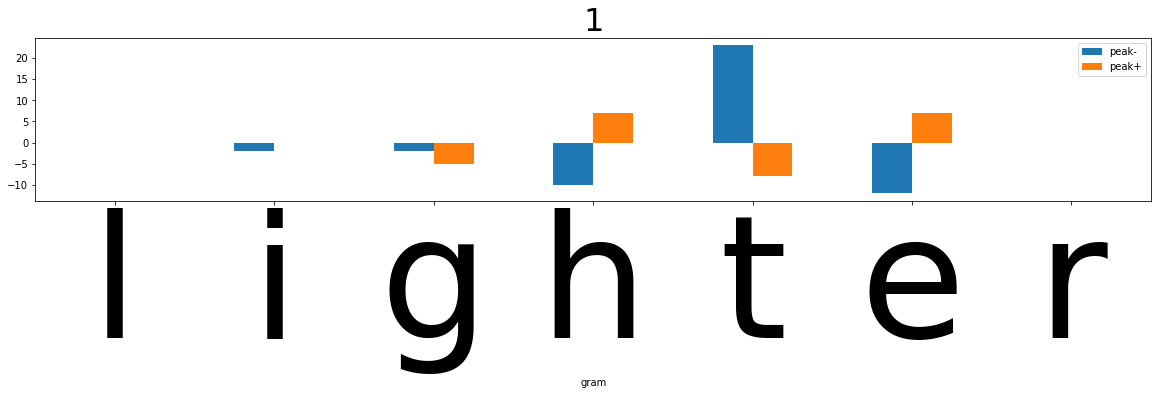

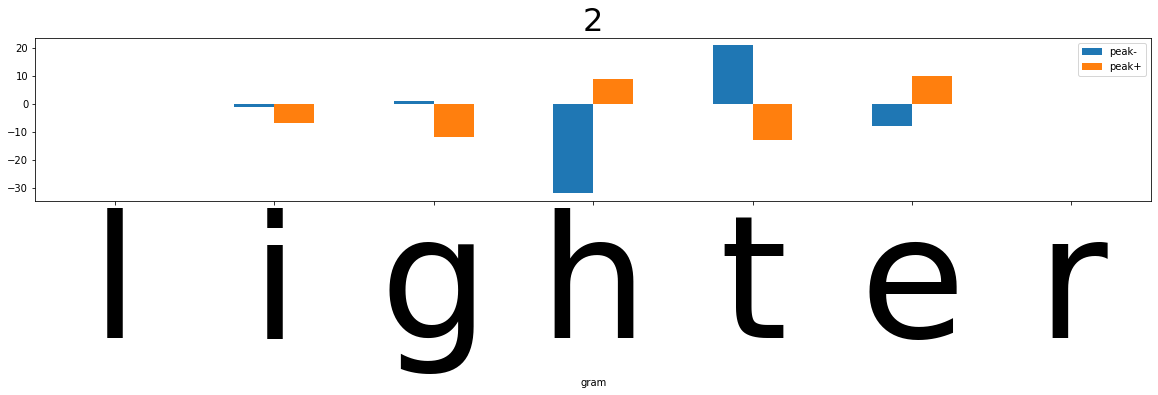

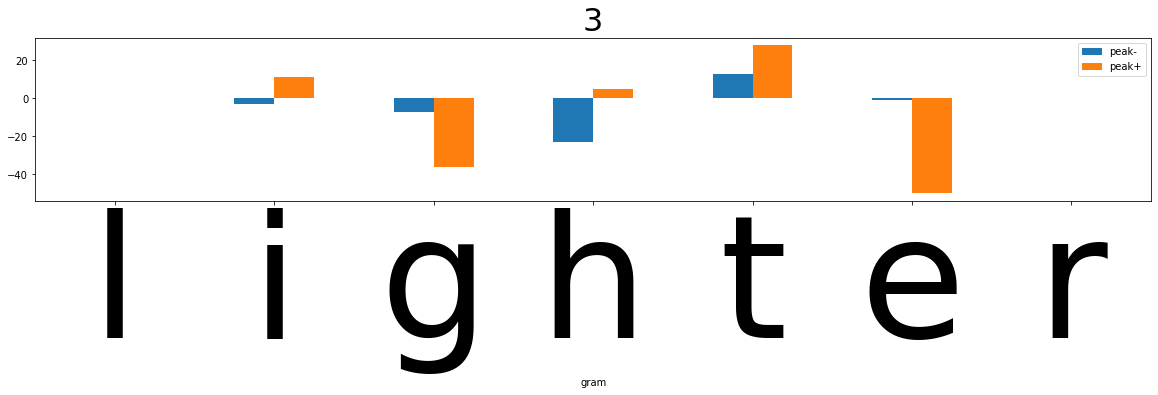

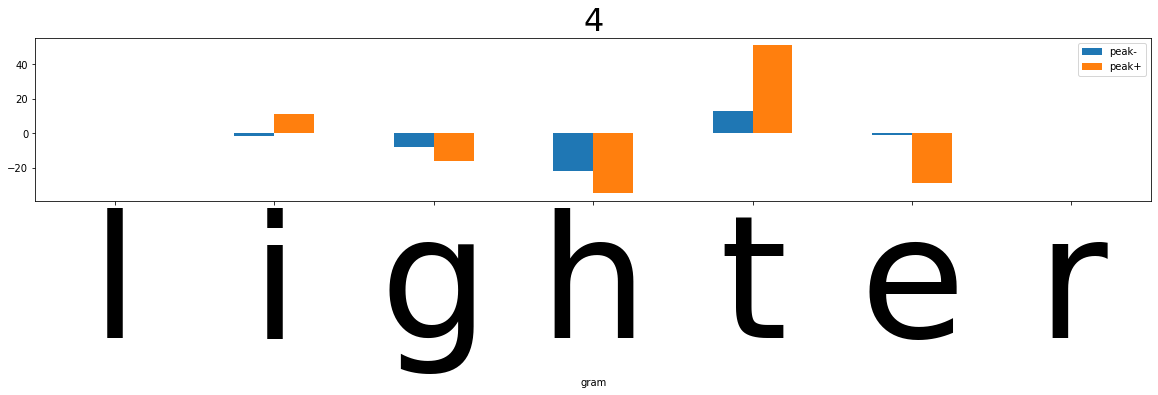

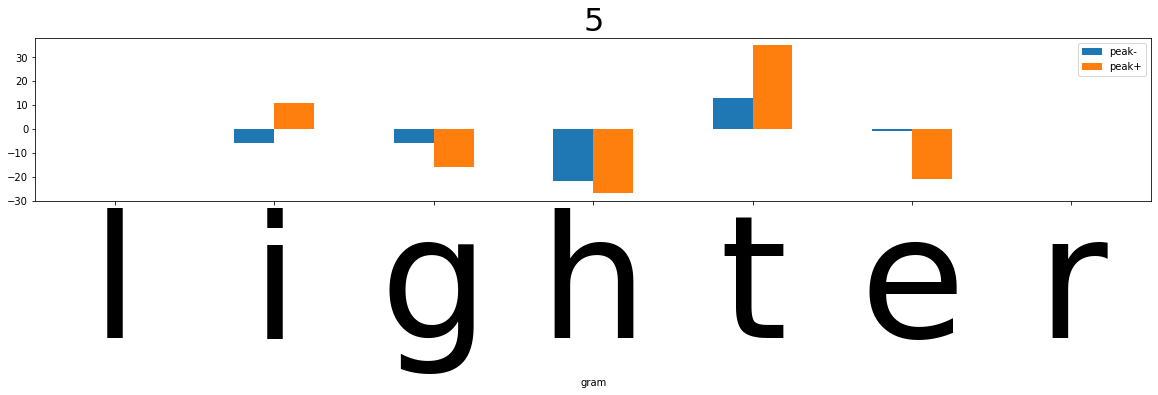

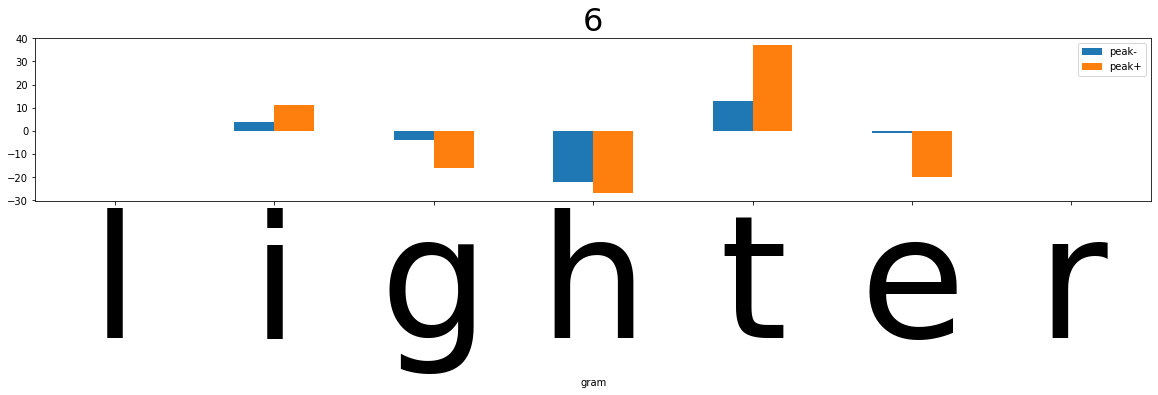

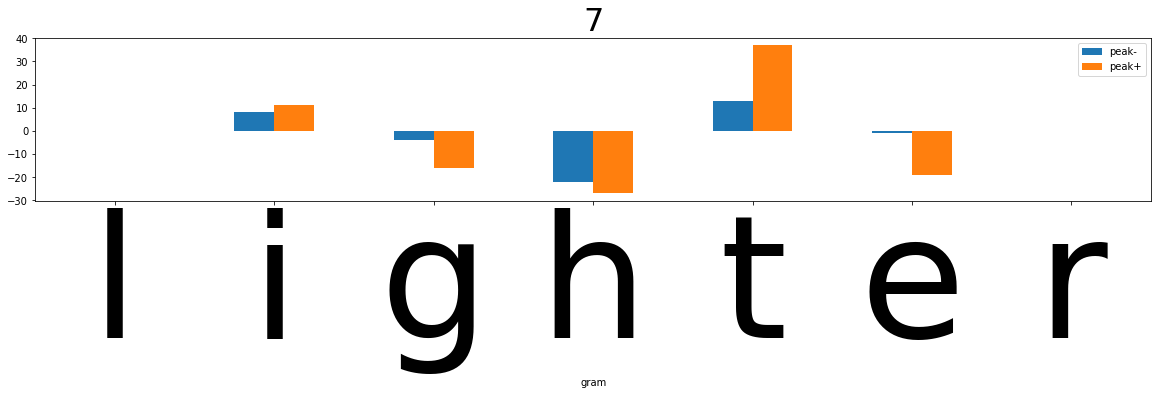

In [474]:
text = 'lighter'
threshold = 0.7
tokenizer = FreedomBasedTokenizer(base,'peak-','peak+')
for n in range(1,7+1):
    tokenizer.set_options(nlist = [n], threshold=threshold)
    t1 = tokenizer.tokenize(text)
    print(t1)
    df = profile_freedoms_ex_df(base.model,text,n)
    plot_bars(df,'gram',['peak-','peak+'],title=str(n))

['pr', 'ogressiv', 'e', 'ly']
['p', 'ro', 'gr', 'e', 's', 'sive', 'ly']
['pro', 'g', 'res', 's', 'ive', 'ly']
['pro', 'gr', 'ess', 'ively']
['pro', 'gres', 's', 'iv', 'ely']
['pro', 'gres', 'sively']
['pro', 'gres', 'sively']


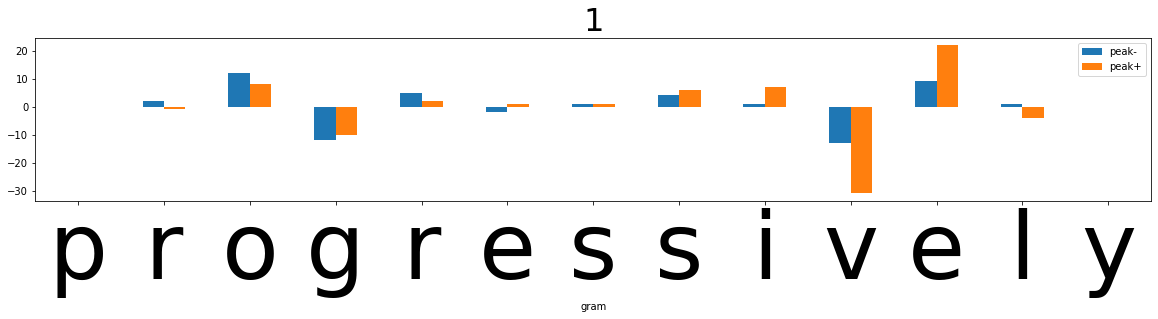

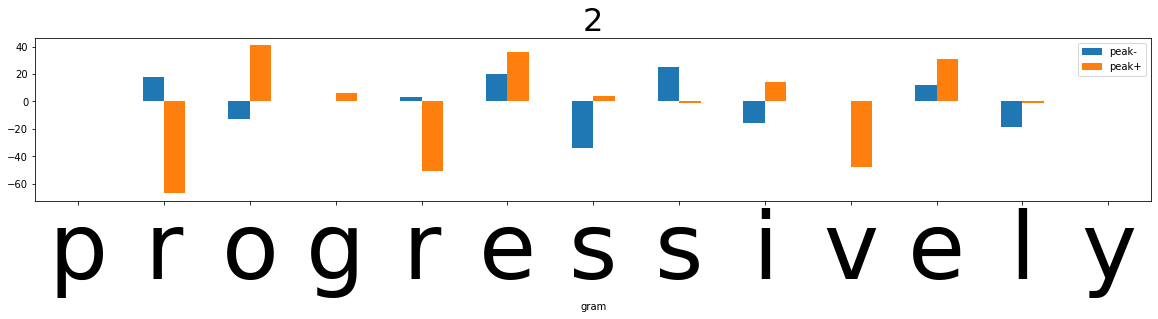

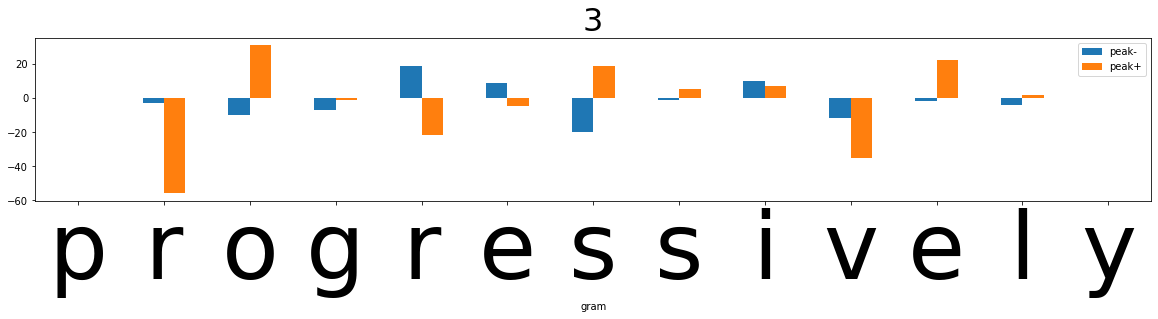

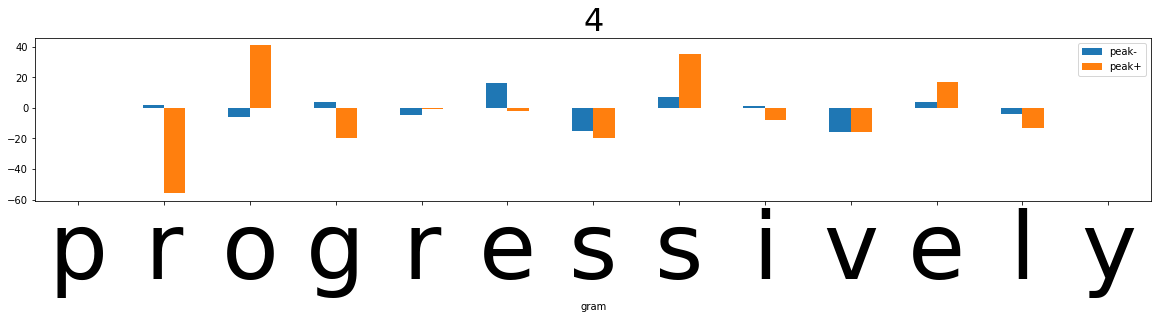

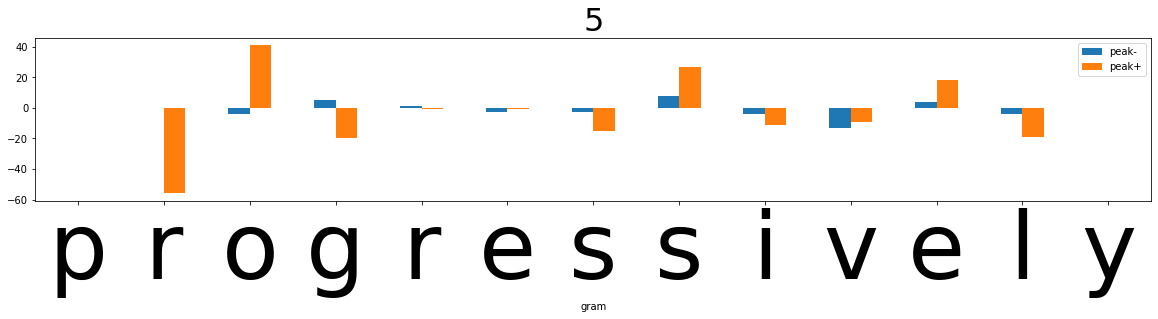

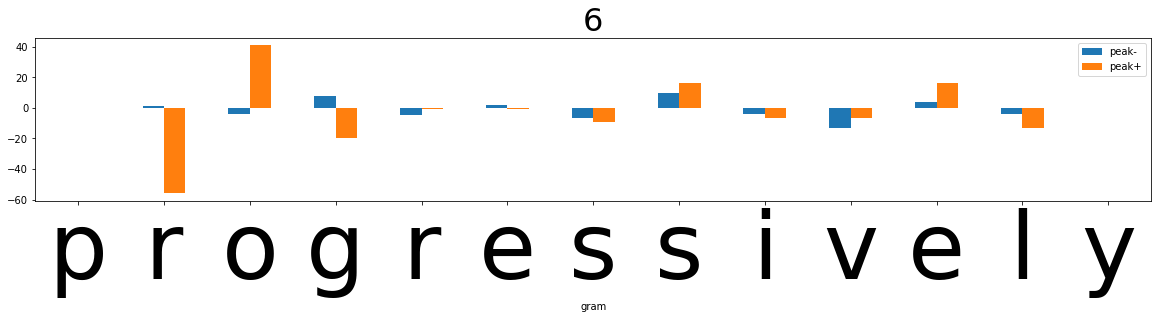

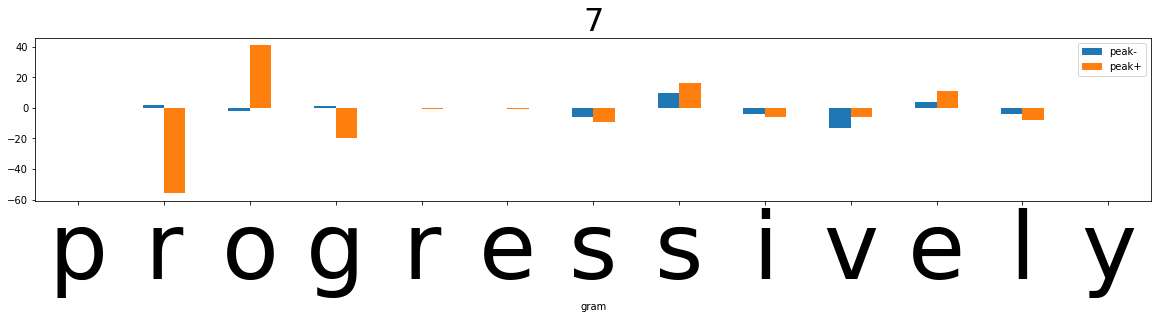

In [476]:
text = 'progressively'
threshold = 0.5
tokenizer = FreedomBasedTokenizer(base,'peak-','peak+')
for n in range(1,7+1):
    tokenizer.set_options(nlist = [n], threshold=threshold)
    t1 = tokenizer.tokenize(text)
    print(t1)
    df = profile_freedoms_ex_df(base.model,text,n)
    plot_bars(df,'gram',['peak-','peak+'],title=str(n))


In [470]:
#brown
for t in test_set:
    s = chunks_tf(base,t,avg=True)
    print(round(s,2),t)
print()
for t in ['l','i','g','h','t','e','r']:
    s = chunks_tf(base,[t],avg=True)
    print(round(s,2),t)
print()
for t in ['li','ig','gh','ht','te','er']:
    s = chunks_tf(base,[t],avg=True)
    print(round(s,2),t)
print()
for t in ['lig','igh','ght','hte','ter']:
    s = chunks_tf(base,[t],avg=True)
    print(round(s,2),t)
print()
for t in ['ligh','ight','ghte','hter']:
    s = chunks_tf(base,[t],avg=True)
    print(round(s,2),t)
print()
for t in ['light','ighte','ghter']:
    s = chunks_tf(base,[t],avg=True)
    print(round(s,2),t)
print()
for t in ['li','ig','gh','ht','ter']:
    s = chunks_tf(base,[t],avg=True)
    print(round(s,2),t)
print()
for t in ['lig','gh','ht','ter']:
    s = chunks_tf(base,[t],avg=True)
    print(round(s,2),t)
print()
for t in ['light','er']:
    s = chunks_tf(base,[t],avg=True)
    print(round(s,2),t)


0.11 ['lighter']
0.43 ['l', 'ighter']
0.39 ['li', 'ghter']
0.24 ['lig', 'hter']
0.46 ['ligh', 'ter']
0.58 ['light', 'er']
0.43 ['lighte', 'r']
0.52 ['l', 'i', 'ghter']
0.46 ['l', 'ig', 'hter']
0.59 ['l', 'igh', 'ter']
0.62 ['l', 'ight', 'er']
0.54 ['l', 'ighte', 'r']
0.49 ['li', 'g', 'hter']
0.61 ['li', 'gh', 'ter']
0.58 ['li', 'ght', 'er']
0.49 ['li', 'ghte', 'r']
0.59 ['lig', 'h', 'ter']
0.49 ['lig', 'ht', 'er']
0.4 ['lig', 'hte', 'r']
0.59 ['ligh', 't', 'er']
0.56 ['ligh', 'te', 'r']
0.64 ['light', 'e', 'r']

0.72 l
0.7 i
0.69 g
0.74 h
0.82 t
0.77 e
0.76 r

0.64 li
0.5 ig
0.5 gh
0.39 ht
0.72 te
0.75 er

0.33 lig
0.36 igh
0.36 ght
0.12 hte
0.7 ter

0.21 ligh
0.39 ight
0.08 ghte
0.14 hter

0.4 light
0.14 ighte
0.14 ghter

0.64 li
0.5 ig
0.5 gh
0.39 ht
0.7 ter

0.33 lig
0.5 gh
0.39 ht
0.7 ter

0.4 light
0.75 er


In [462]:
#brown
for t in test_set:
    s = chunks_pr(base,t,avg=True)
    print(round(s,2),t)
print()
for t in ['li','ig','gh','ht','te','er']:
    s = chunks_pr(base,[t],avg=True)
    print(round(s,4),t)
print()
for t in ['lig','igh','ght','hte','ter']:
    s = chunks_pr(base,[t],avg=True)
    print(round(s,4),t)
print()
for t in ['ligh','ight','ghte','hter']:
    s = chunks_pr(base,[t],avg=True)
    print(round(s,4),t)
print()
for t in ['light','ighte','ghter']:
    s = chunks_pr(base,[t],avg=True)
    print(round(s,4),t)
print()
for t in ['li','ig','gh','ht','ter']:
    s = chunks_pr(base,[t],avg=True)
    print(round(s,4),t)
print()
for t in ['lig','gh','ht','ter']:
    s = chunks_pr(base,[t],avg=True)
    print(round(s,4),t)
print()
for t in ['light','er']:
    s = chunks_pr(base,[t],avg=True)
    print(round(s,4),t)


0.0 ['lighter']
0.02 ['l', 'ighter']
0.0 ['li', 'ghter']
0.0 ['lig', 'hter']
0.0 ['ligh', 'ter']
0.01 ['light', 'er']
0.02 ['lighte', 'r']
0.03 ['l', 'i', 'ghter']
0.01 ['l', 'ig', 'hter']
0.01 ['l', 'igh', 'ter']
0.02 ['l', 'ight', 'er']
0.03 ['l', 'ighte', 'r']
0.01 ['li', 'g', 'hter']
0.0 ['li', 'gh', 'ter']
0.01 ['li', 'ght', 'er']
0.02 ['li', 'ghte', 'r']
0.02 ['lig', 'h', 'ter']
0.0 ['lig', 'ht', 'er']
0.02 ['lig', 'hte', 'r']
0.03 ['ligh', 't', 'er']
0.02 ['ligh', 'te', 'r']
0.05 ['light', 'e', 'r']

0.0039 li
0.0017 ig
0.0017 gh
0.001 ht
0.0072 te
0.0127 er

0.0003 lig
0.001 igh
0.001 ght
0.0001 hte
0.0021 ter

0.0002 ligh
0.0007 ight
0.0001 ghte
0.0 hter

0.0002 light
0.0001 ighte
0.0 ghter

0.0039 li
0.0017 ig
0.0017 gh
0.001 ht
0.0021 ter

0.0003 lig
0.0017 gh
0.001 ht
0.0021 ter

0.0002 light
0.0127 er


In [ ]:
#input: lexicon

In [ ]:
def word_break(word):
    # find most probable piece, take it out
    # find next, do the same
    
    